In [1]:
#default_exp sr_unet_floss

# fastai unet + feature_loss

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#export
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import vgg16_bn

In [4]:
import sys
sys.path.append('..')
from superres.datasets import *
from superres.databunch import *

In [5]:
seed = 8610
random.seed(seed)
np.random.seed(seed)

## Feature Loss

In [6]:
# export
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [7]:
# export
base_loss = F.l1_loss

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [8]:
# export
def create_feature_loss()->FeatureLoss:
    """ Create FeatureLoss """
    vgg_m = vgg16_bn(True).features.cuda().eval()
    requires_grad(vgg_m, False)
    blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
    return FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## DataBunch

In [9]:
train_hr = div2k_train_hr_crop_256

In [10]:
in_size = 256
out_size = 256
scale = 4
bs = 10

ImageDataBunch;

Train: LabelList (25245 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/jovyan/notebook/datasets/DIV2K/DIV2K_train_HR_crop/256;

Valid: LabelList (6311 items)
x: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: ImageImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /home/jovyan/notebook/datasets/DIV2K/DIV2K_train_HR_crop/256;

Test: None


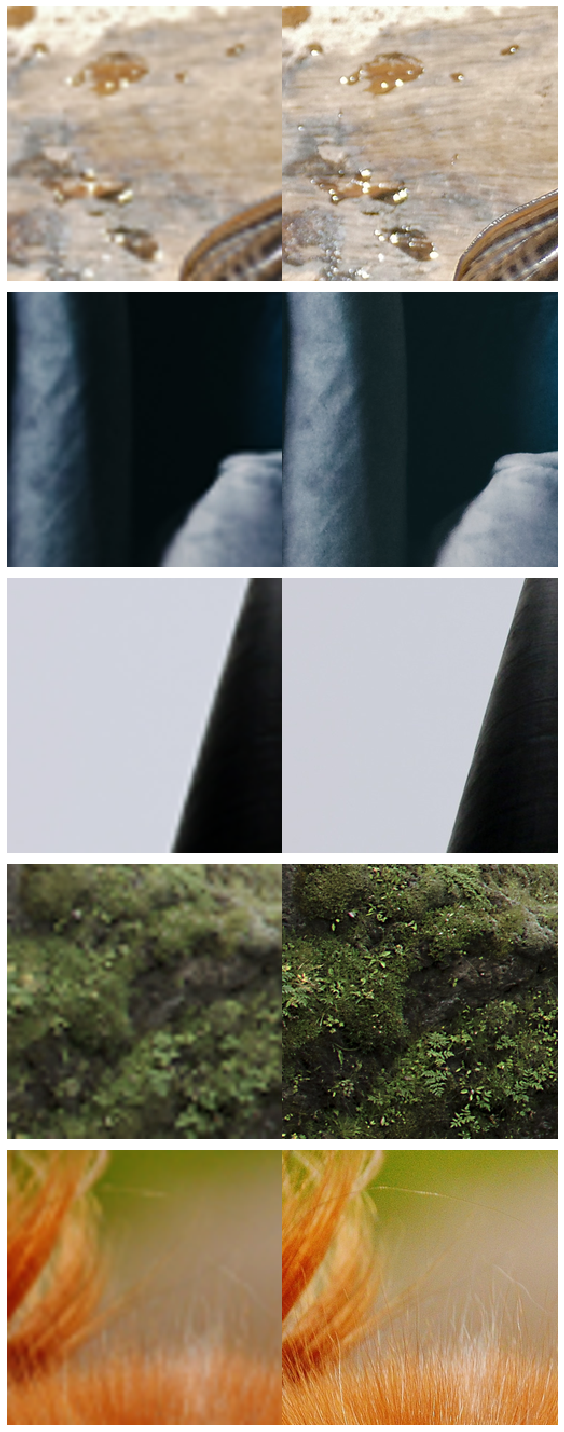

In [11]:
data = create_sr_databunch(train_hr, in_size=in_size, out_size=out_size, scale=scale, bs=bs, seed=seed)
print(data)
data.show_batch()

## Training

In [12]:
model = models.resnet34
loss_func = create_feature_loss()
metrics = [m_psnr, m_ssim]
callback_fns = LossMetrics
wd = 1e-3
y_range = (-3.,3.)
model_name = 'feat_loss'

In [13]:
learn = unet_learner(data, model, wd=wd, metrics=metrics, y_range=y_range,
                     loss_func=loss_func, callback_fns=callback_fns,
                     blur=True, norm_type=NormType.Weight, self_attention=True)
learn.path = Path('.')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-04
Min loss divided by 10: 6.31E-04


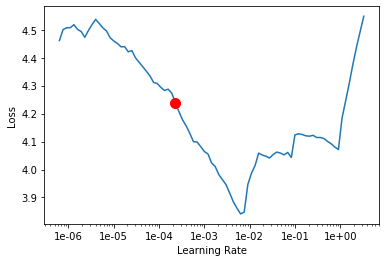

In [14]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [15]:
lr = 1e-3
lrs = slice(lr)
epoch = 3
pct_start = 0.3
wd = 1e-3
save_fname = model_name

In [16]:
callbacks = [ShowGraph(learn), SaveModelCallback(learn, name=save_fname)]

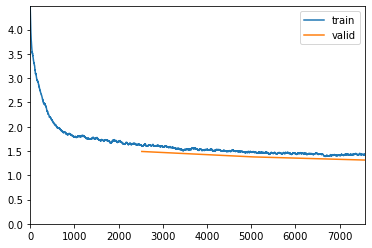

Better model found at epoch 0 with valid_loss value: 1.489443302154541.
Better model found at epoch 1 with valid_loss value: 1.377553939819336.
Better model found at epoch 2 with valid_loss value: 1.312827706336975.


In [17]:
learn.fit_one_cycle(epoch, lrs, pct_start=pct_start, wd=wd, callbacks=callbacks)

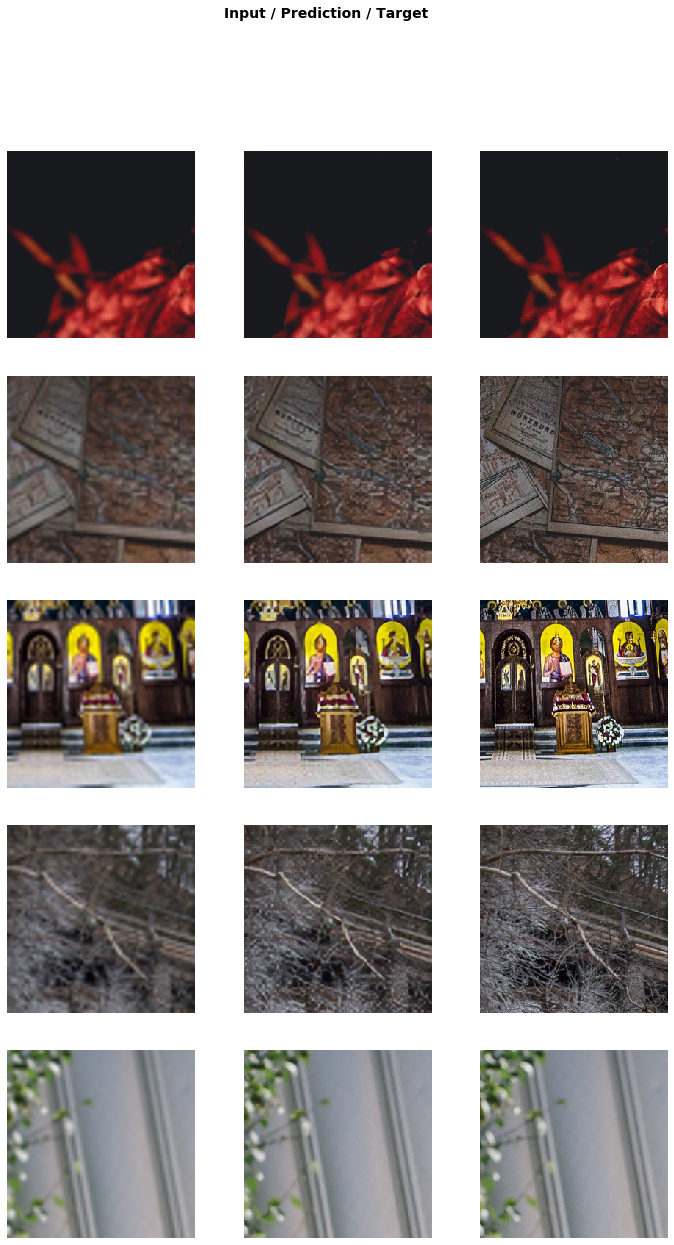

In [18]:
learn.show_results()

## Test

In [19]:
test_hr = set14_hr

In [20]:
il_test_x = ImageImageList.from_folder(test_hr, after_open=partial(after_open_image, size=in_size, scale=4, sizeup=True))
il_test_y = ImageImageList.from_folder(test_hr, after_open=partial(after_open_image, size=out_size))

In [21]:
_ = learn.load(save_fname)

bicubic: PSNR:24.11,SSIM:0.7822
feat_loss:	 PSNR:25.13,SSIM:0.8130


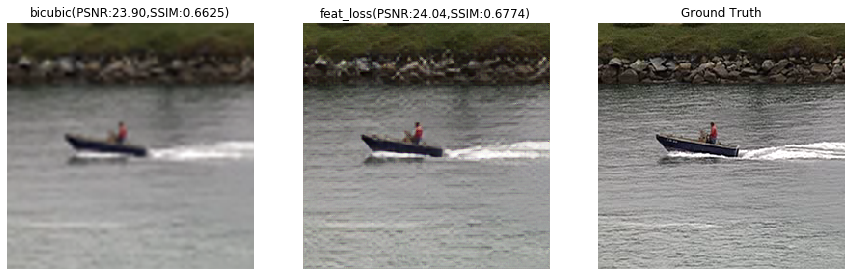

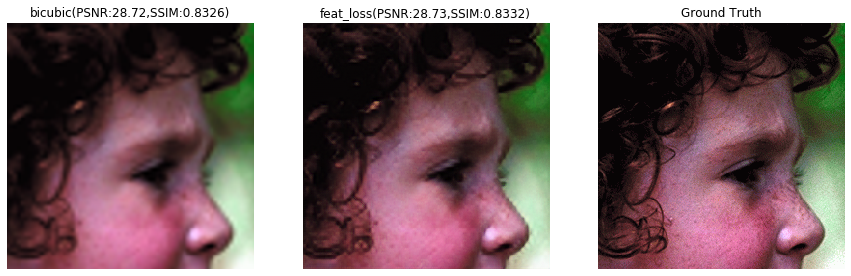

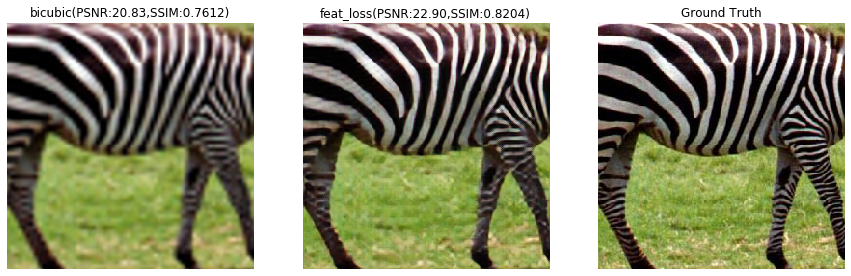

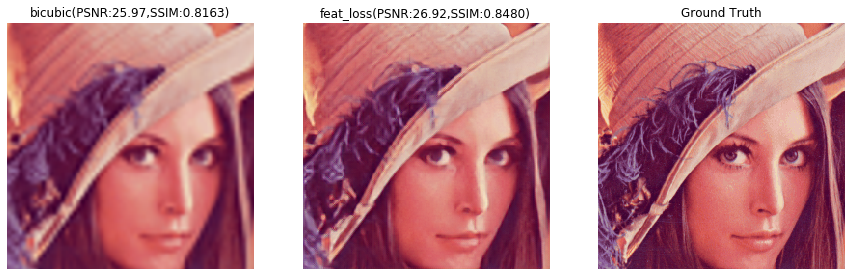

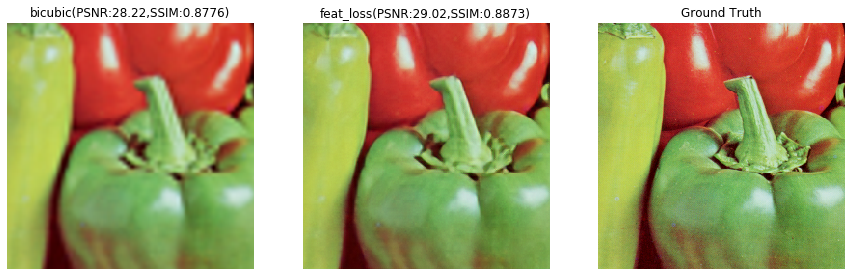

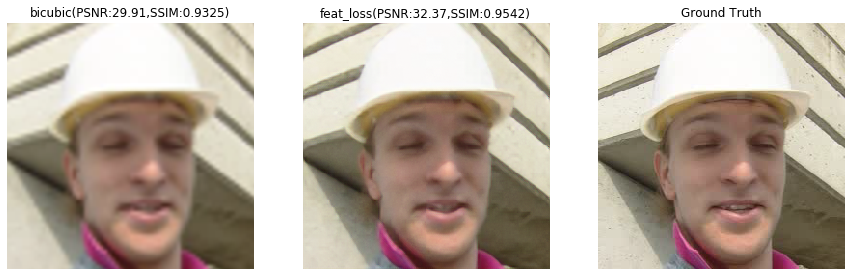

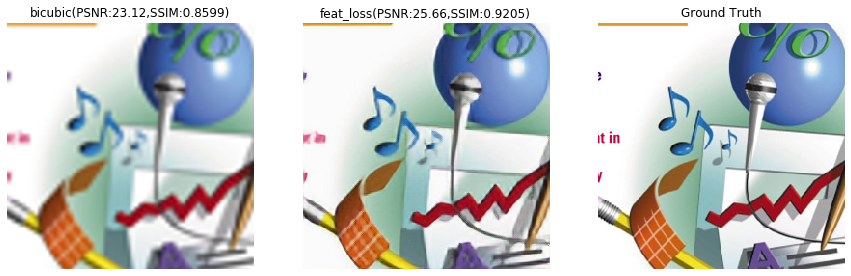

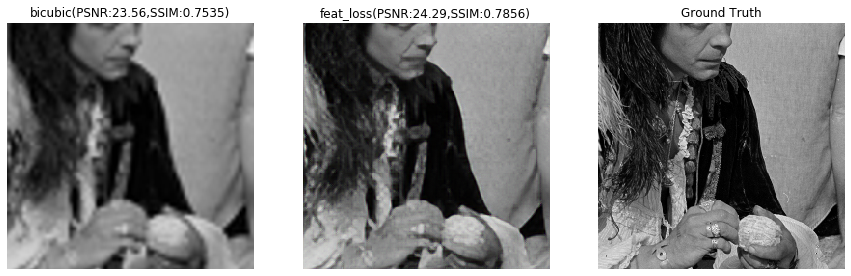

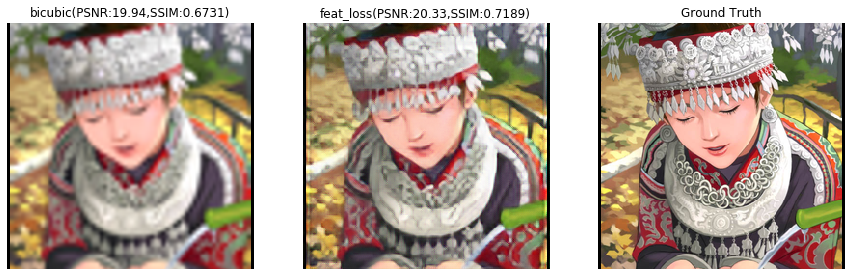

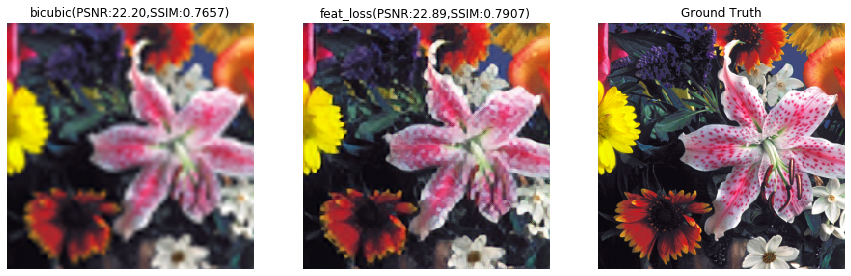

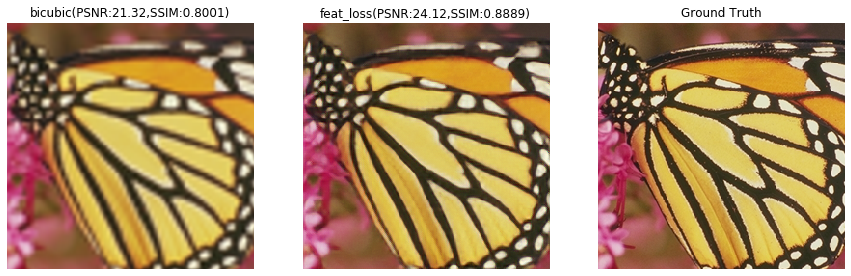

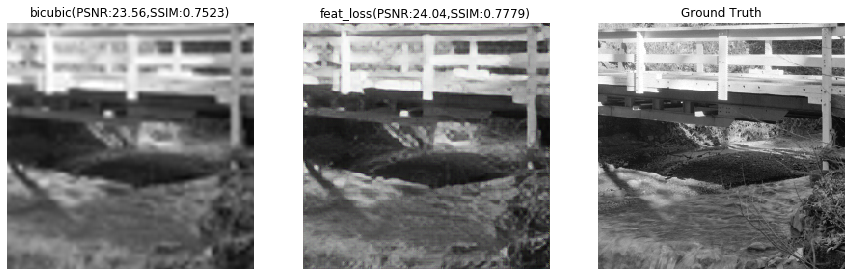

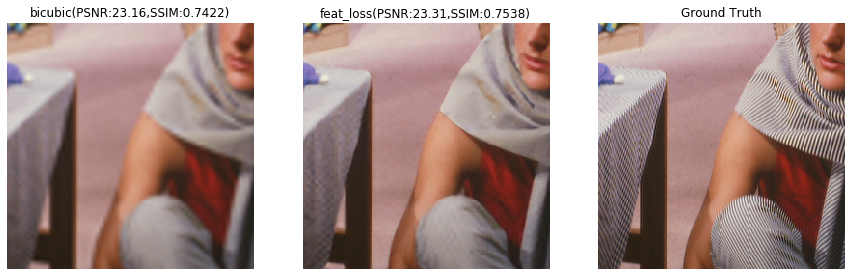

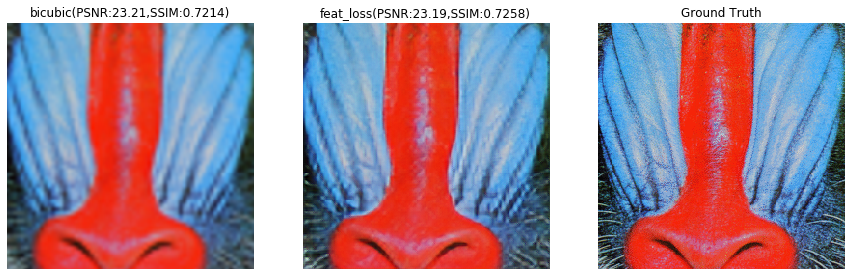

In [22]:
sr_test(learn, il_test_x, il_test_y, model_name)

## Report

In [23]:
model

<function torchvision.models.resnet.resnet34(pretrained=False, progress=True, **kwargs)>

In [24]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
__________________________________________________